In [34]:
import json
from matplotlib import pyplot as plt
import numpy as np
import os
import sys
import open3d as o3d
from fastdtw import fastdtw
from scipy.spatial.distance import euclidean
from scipy.ndimage import gaussian_filter1d
import time
import moviepy.video.io.ImageSequenceClip
import copy
import networkx as nx
import math
sys.path.insert(0,'/Users/evanpan/Documents/GitHub/EvansToolBox/Utils')

from Signal_processing_utils import dx_dt, get_activity_interval, bilateral_filter_smoothing
from Interpolation_Util import CubicSplineInterpolation, CatmullRomSplineInterpolation
from sklearn.linear_model import Ridge
from utils import *
from Speech_Data_util import *
import textgrid

In [35]:
%load_ext autoreload
%autoreload 1
%aimport utils
%aimport Signal_processing_utils
%aimport Interpolation_Util
# %matplotlib widget
%matplotlib inline


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Utils

In [36]:
def to_vals_dict(names, curves):
    out = {}
    for n in range(len(names)):
        out[names[n]] = curves[:, n]
    return out
from scipy.interpolate import interp1d
class MarlarkiRelativeTimeInterpolation:
    def __init__(self, x, y, ctpt_x, ctpt_y, tao=0.5, lower_bound=None):
        # these will be unchanging
        self.x = np.array(copy.deepcopy(x))
        self.y = np.array(copy.deepcopy(y))
        # these are the interp functions 
        self.curves_list: list[interp1d] = []
        self.extra_start = 0 # see if there is an additional keyframe added at frame 0
        self.extra_end = 0 # see if there is an additional keyframe added at the final frame
        # this can be used 
        self.range_list = [] # this contains inclusive range, such that if range is [1, 2] the interval contains points with index 1 and 2
        # this will be modifier for range
        self.range_delta_list = []
        
        # the control points
        self.ctpt_x = copy.deepcopy(ctpt_x) # time is never directly changed
        self.ctpt_x_delta = [] 
        self.ctpt_y = copy.deepcopy(ctpt_y) # values are manipulated
        
        # if the very first frame is not a keyframe, we add one 
        if self.ctpt_x[0] != self.x[0]: 
            start_index = 0
            end_index = self.__binary_search(self.ctpt_x[0])
            x_prime = ((self.x[start_index:end_index+1]) - self.x[start_index]) / (self.x[end_index] - self.x[start_index])
            self.curves_list.append(interp1d(x_prime, self.y[start_index:end_index+1], bounds_error=False))
            self.range_list.append([start_index, end_index])
            self.extra_start = 1
        # start on the second frame if 
        for i in range(0, self.ctpt_x.shape[0] - 1):
            start_index = self.__binary_search(self.ctpt_x[i])
            end_index = self.__binary_search(self.ctpt_x[i+1])
            x_prime = ((self.x[start_index:end_index+1]) - self.x[start_index]) / (self.x[end_index] - self.x[start_index])
            self.curves_list.append(interp1d(x_prime, self.y[start_index:end_index+1], bounds_error=False))
            self.range_list.append([start_index, end_index])
        if self.ctpt_x[-1] != self.x[-1]: 
            start_index = self.__binary_search(self.ctpt_x[-1])
            end_index = self.__binary_search(self.x[-1])
            x_prime = ((self.x[start_index:end_index+1]) - self.x[start_index]) / (self.x[end_index] - self.x[start_index])
            self.curves_list.append(interp1d(x_prime, self.y[start_index:end_index+1], bounds_error=False))
            self.range_list.append([start_index, end_index])
            self.extra_end = 1
        for i in range(0, len(self.range_list)):
            self.range_delta_list.append([0, 0])
        for i in range(0, self.ctpt_x.shape[0]):
            self.ctpt_x_delta.append(0)
    def __binary_search(self, t):
        if t <= self.x[0]:
            return 0
        elif t > self.x[-1]:
            return self.x.shape[0]-1
        # find it
        left, right = 0, self.x.shape[0] - 1
        index = -1
        while left <= right:
            mid = (left + right) // 2
            
            if self.x[mid] < t:
                index = mid
                left = mid + 1
            else:
                right = mid - 1
        return index+1
    def __find_range(self, t):
        for i in range(0, len(self.range_list)):
            if t >= self.x[self.range_list[i][0]] + self.range_delta_list[i][0] and t <= self.x[self.range_list[i][1]] + self.range_delta_list[i][1]:
                return i
        return -1
    def eval_single(self, x):
        # here we ensure that we will never get to the end of the curve
        if x <= self.x[0]:
            return self.y[0]
        elif x >= self.x[-1]:
            return self.y[-1]
        # find the range that contains both x
        curve_id = self.__find_range(x)
        # get the range (i.e. the two keyframes)
        curve_range = self.range_list[curve_id]
        curve_delta = self.range_delta_list[curve_id]
        # get the normalized time value
        x_prime = (x - self.x[curve_range[0]]-curve_delta[0]) / (self.x[curve_range[1]] + curve_delta[1] - self.x[curve_range[0]] - curve_delta[0])
        # evaluate the value:
        curve = self.curves_list[curve_id]
        return curve(x_prime)
    def eval(self, ts):
        out = np.zeros(ts.shape)
        for i in range(0, ts.shape[0]):
            out[i] = self.eval_single(ts[i])
        return out
    def update_y(self, ctpt_id, new_val):
        # i.e. the n-the control point correcsponds to the n-th range with the ctpt on the left
        curve_id = ctpt_id + self.extra_start 
        old_val = self.ctpt_y[ctpt_id]
        if curve_id-1 >= 0:
            curve_range_km1 = self.range_list[curve_id-1]
            # this is inclusive range
            l_ratio = (new_val - self.y[curve_range_km1[0]])/(old_val - self.y[curve_range_km1[0]])
            if self.y[curve_range_km1[1]] - self.y[curve_range_km1[0]] == 0:
                l_ratio = 0
            if abs(l_ratio) > 100:
                l_ratio = (new_val)/(old_val)
            self.y[curve_range_km1[0]:curve_range_km1[1]+1] = (self.y[curve_range_km1[0]:curve_range_km1[1]+1] - self.y[curve_range_km1[0]]) * l_ratio + self.y[curve_range_km1[0]]
            self.curves_list[curve_id-1] = (interp1d(self.curves_list[curve_id-1].x, self.y[curve_range_km1[0]:curve_range_km1[1]+1], bounds_error=False))  
            self.y[curve_range_km1[1]] = new_val 
        if curve_id < len(self.range_list):
            curve_range_kp1 = self.range_list[curve_id]
            self.y[curve_range_kp1[0]] = old_val
            r_ratio = (new_val - self.y[curve_range_kp1[1]])/(old_val - self.y[curve_range_kp1[1]])
            if self.y[curve_range_kp1[0]] - self.y[curve_range_kp1[1]] == 0:
                r_ratio = 0
            if abs(r_ratio) > 100:
                r_ratio = (new_val)/(old_val)
            self.y[curve_range_kp1[0]:curve_range_kp1[1]+1] = (self.y[curve_range_kp1[0]:curve_range_kp1[1]+1] - self.y[curve_range_kp1[1]]) * r_ratio + self.y[curve_range_kp1[1]]
            self.curves_list[curve_id] = interp1d(self.curves_list[curve_id].x, self.y[curve_range_kp1[0]:curve_range_kp1[1]+1], bounds_error=False)
            self.y[curve_range_kp1[0]] = new_val 
        self.ctpt_y[ctpt_id] = new_val 
    def update_x(self, ctpt_id, new_delta):
        # update the control point delta
        self.ctpt_x_delta[ctpt_id] = new_delta
        # do the same to the intervals
        right_interval_id = ctpt_id + self.extra_start
        # update the delta in control point
        if right_interval_id < len(self.range_delta_list):
            self.range_delta_list[right_interval_id][0] = new_delta
        if right_interval_id - 1 > 0:
            self.range_delta_list[right_interval_id-1][1] = new_delta
    def get_ctpt_xs(self):
        rtv = np.zeros(self.ctpt_x.shape)
        for i in range(0, len(self.ctpt_x)):
            rtv[i] = self.ctpt_x_delta[i] + self.ctpt_x[i]
        return rtv

# Inputs

In [37]:
DATA_PATH = "/Users/evanpan/Documents/GitHub/facial-PAE/datasets/30/"
FILE_NAME = "30_katya_0_87_88"

BS_DATAPATH = os.path.join(DATA_PATH, FILE_NAME+".json")
AUDIO_DATAPATH = os.path.join(DATA_PATH, FILE_NAME+".wav")
PHONEME_DATAPATH = os.path.join(DATA_PATH, FILE_NAME+".textgrid")

mesh_to_name_path = "/Users/evanpan/Documents/GitHub/staggered_face/models/joonho_mesh_number_to_AU_name.json"
name_to_mesh_path = "/Users/evanpan/Documents/GitHub/staggered_face/models/joonho_AU_name_to_mesh_number.json"
out_path = "/Volumes/EVAN_DISK/MASC/staggered_face/Pilot_Experimental_study/Iphone_AR_kit/evan_take_jul4/for_maya_json.json"
model_path = "/Users/evanpan/Documents/GitHub/staggered_face/data/Apple blendshapes51 OBJs/OBJs"

In [38]:
data = json.load(open(BS_DATAPATH))
names = data["names"]
time_end = len(data["frames"])
time_end = 2000

curves = np.zeros([time_end, 51])
times = np.zeros([time_end, ])

for i in range(0, time_end):
    curves[i] = np.array(data["frames"][i]["weights"])
    times[i] = np.array(data["frames"][i]["time"])
vals_dict = to_vals_dict(names, curves)
ARkit_2_blendshapeModel_map = {'eyeblink_r': 'eyeblinkright', 'eyelookdown_r': 'eyelookdownright', 'eyelookin_r': 'eyelookinright', 'eyelookout_r': 'eyelookoutright', 'eyelookup_r': 'eyelookupright', 'eyesquint_r': 'eyesquintright', 'eyewide_r': 'eyewideright', 'eyeblink_l': 'eyeblinkleft', 'eyelookdown_l': 'eyelookdownleft', 'eyelookin_l': 'eyelookinleft', 'eyelookout_l': 'eyelookoutleft', 'eyelookup_l': 'eyelookupleft', 'eyesquint_l': 'eyesquintleft', 'eyewide_l': 'eyewideleft', 'jawforward': 'jawforward', 'jawright': 'jawright', 'jawleft': 'jawleft', 'jawopen': 'jawopen', 'mouthclose': 'mouthclose', 'mouthfunnel': 'mouthfunnel', 'mouthpucker': 'mouthpucker', 'mouthright': 'mouthright', 'mouthleft': 'mouthleft', 'mouthsmile_r': 'mouthsmileright', 'mouthsmile_l': 'mouthsmileleft', 'mouthfrown_r': 'mouthfrownright', 'mouthfrown_l': 'mouthfrownleft', 'mouthdimple_r': 'mouthdimpleright', 'mouthdimple_l': 'mouthdimpleleft', 'mouthstretch_r': 'mouthstretchright', 'mouthstretch_l': 'mouthstretchleft', 'mouthrolllower': 'mouthrolllower', 'mouthrollupper': 'mouthrollupper', 'mouthshruglower': 'mouthshruglower', 'mouthshrugupper': 'mouthshrugupper', 'mouthpress_r': 'mouthpressright', 'mouthpress_l': 'mouthpressleft', 'mouthlowerdown_r': 'mouthlowerdownright', 'mouthlowerdown_l': 'mouthlowerdownleft', 'mouthupperup_r': 'mouthupperupright', 'mouthupperup_l': 'mouthupperupleft', 'browdown_r': 'browdownright', 'browdown_l': 'browdownleft', 'browinnerup': 'browinnerup', 'browouterup_r': 'browouterupright', 'browouterup_l': 'browouterupleft', 'cheekpuff': 'cheekpuff', 'cheeksquint_r': 'cheeksquintright', 'cheeksquint_l': 'cheeksquintleft', 'nosesneer_r': 'nosesneerright', 'nosesneer_l': 'nosesneerleft'}

In [79]:
calibration_data_path = "/Volumes/EVAN_DISK/MASC/staggered_face/Pilot_Experimental_study/Iphone_AR_kit/evan_take_jul4/MySlate_17_iPhone_cal.csv"
times, values_dict = load_apple_motion(calibration_data_path, 30, calibration_data_path)
vals_dict = {}
for key in values_dict:
    key_mod = copy.deepcopy(key)
    key_mod = key_mod[0].lower() + key_mod[1:]
    vals_dict[key_mod] = values_dict[key]

In [81]:
model = BasicBlendshapeModel()
model = load_blendshape_model(model_path, model)
animation = BlendshapeAnimation(model, values_dict=vals_dict, ts =times)
# play_animation(animation, save_video=True)


# Find Overall Keyframes

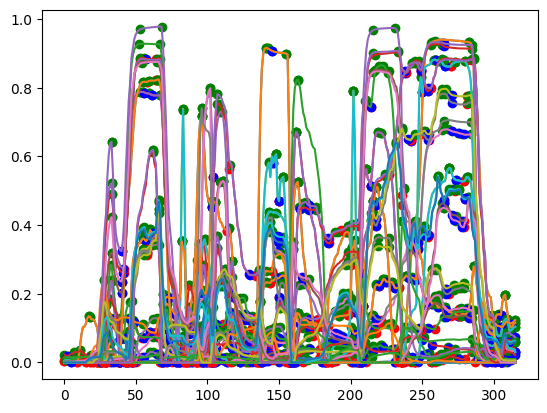

In [82]:
onset_threshold = 0.05
offset_threshold = 0.05
noise_threshold = 0.2
plt.clf()
curve_index = 0
onset_curve_dict = {}
offset_curve_dict = {}
labeled_key_frame_dict = {}
for i in range(curve_index, len(names)):
    au_i = names[i]
    au_i_curve = vals_dict[au_i]
    filtered_au_i_curve = au_i_curve
    plt.plot(filtered_au_i_curve, label="original")
    # find onset
    au_i_vel_curve_forward = dx_dt(filtered_au_i_curve, dt=1/30.0, method=1)
    au_i_vel_curve_backward = dx_dt(filtered_au_i_curve, dt=1/30.0, method=3)
    onsets = np.zeros(au_i_vel_curve_forward.shape)
    offsets = np.zeros(au_i_vel_curve_forward.shape)
    ts = list(range(0, au_i_vel_curve_forward.shape[0]))
    for t in ts:
        # if the AU is increasing sufficiently we set the element in the onsets array it to 1
        # here we use backward differences to capture the onset t[i+1] - t[i]
        if au_i_vel_curve_backward[t] >= onset_threshold or au_i_vel_curve_forward[t] >= onset_threshold: 
            onsets[t] = 1
        # if the AU is decreasing sufficiently we set the element in the offsets array it to 1
        # here we use backward difference 
        if au_i_vel_curve_forward[t] <= -offset_threshold or au_i_vel_curve_backward[t] <= -offset_threshold:
            offsets[t] = 1
    # merge nearby active labels into intervals. (i.e. if there is a group of 1s they are now clustered)
    action_unit_onset_activity = get_activity_interval(onsets, np.array(ts))
    action_unit_offset_activity = get_activity_interval(offsets, np.array(ts))
    onset_curve_dict[au_i] = onsets
    offset_curve_dict[au_i] = offsets
    # activation, peak, sustain and deactivation values
    activation = [x[0] for x in action_unit_onset_activity]
    peak = [x[1] for x in action_unit_onset_activity]
    sustain = [x[0] for x in action_unit_offset_activity]
    deactivation = [x[1] for x in action_unit_offset_activity]
    # plot all the key points
    labeled_key_frames = []
    plt.scatter(activation, filtered_au_i_curve[activation], c="r", label="motion onset")
    plt.scatter(peak, filtered_au_i_curve[peak], c="g", label="motion peak")
    plt.scatter(sustain, filtered_au_i_curve[sustain], c="g", label="motion sustain")
    plt.scatter(deactivation, filtered_au_i_curve[deactivation], c="b", label="motion end")
    for pts in activation:
        labeled_key_frames.append([pts, "a"])
    for pts in peak:
        labeled_key_frames.append([pts, "p"])
    for pts in sustain:
        labeled_key_frames.append([pts, "s"])
    for pts in deactivation:
        labeled_key_frames.append([pts, "d"])
    # sort all the potential key frames by time
    if len(labeled_key_frames) == 0:
        labeled_key_frames = [[0, "a"], [len(ts)-1, "d"]]
    labeled_key_frames = sorted(labeled_key_frames, key=lambda x: x[0])
    filtered_labeled_kay_frames = []
    ff = 0
    while ff < len(labeled_key_frames) - 1:
        current = labeled_key_frames[ff]
        next = labeled_key_frames[ff+1]
        if current[0] != next[0]:
            filtered_labeled_kay_frames.append(current)
        # elif (current[1] == "a" and next[1] == "p") or (current[1] == "s" and next[1] == "d"):
        elif (current[1] == "a" and next[1] == "d") or (current[1] == "d" and next[1] == "a"):
            filtered_labeled_kay_frames.append([current[0], "d"])
            # filtered_labeled_kay_frames.append([current[0], "a"])
            ff += 1
        elif au_i_curve[current[0]] <= noise_threshold:
            filtered_labeled_kay_frames.append([current[0], "z"])
            # filtered_labeled_kay_frames.append([current[0], "z"])
            ff += 1
        ff += 1
    # add the last frame (which is probably missing )
    filtered_labeled_kay_frames.append(labeled_key_frames[-1])
    # replace the keyframed with the filtered version
    labeled_key_frames = copy.deepcopy(filtered_labeled_kay_frames)
    # save the keyframe
    labeled_key_frame_dict[au_i] = labeled_key_frames
    plotting_key_frames = [x[0] for x in labeled_key_frames]
    approximation = CatmullRomSplineInterpolation(np.array(ts)[plotting_key_frames], filtered_au_i_curve[plotting_key_frames], tao=0.2)
    # plt.plot(np.maximum(0, approximation.eval(np.array(ts))), label="catmull rom")

In [83]:
kf_width = 3

In [84]:
times = np.array(times)
kf_times_dict = {}
kf_times_aggregate = np.zeros(times.shape)
for key in labeled_key_frame_dict:
    kf_indices = labeled_key_frame_dict[key]
    kf_indices = [x[0] for x in kf_indices]
    kf_times = np.zeros(times.shape)
    for t in range(0, len(kf_indices)):
        kf_times[kf_indices[t]] = 1
    kf_times = gaussian_filter1d(kf_times, kf_width) 
    kf_times_aggregate += kf_times
    kf_times_dict[key] = kf_times

### Visualize KeyFrames

In [85]:
from scipy.signal import argrelextrema
thre = 4
# for local extremes on the aggregated curve
extremes = argrelextrema(kf_times_aggregate, np.greater)[0]
extremes_filtered = []
for i in range(0, len(extremes)):
    if kf_times_aggregate[extremes[i]] >= thre:
        extremes_filtered.append(extremes[i])
# plt.clf()
# plt.plot(times, kf_times_aggregate, label="aggregated activation")
# plt.scatter(times[extremes_filtered], kf_times_aggregate[extremes_filtered], c="r", label="keyframe")
# plt.legend()
# plt.show()


In [86]:
superframes:list[SuperFrame] = []
for i in range(0, len(extremes_filtered)):
    # time of a global keyframe
    kf_time = extremes_filtered[i]
    # add all the keyframes within a certain distance from these key points
    groupings = []
    for key in kf_times_dict:
        for isolated_kf_time in labeled_key_frame_dict[key]:
            if abs(isolated_kf_time[0] - kf_time) <= kf_width:
                groupings.append([key, isolated_kf_time[0]])
    superframes.append(SuperFrame(groupings))
visualize_superpose(animation, superframes, vals_dict, True, "/Users/evanpan/Desktop/super_pose_summation_w=3.mp4", pause_length=0)

[Open3D WARNING] GLFW Error: Cocoa: Failed to find service port for display
Moviepy - Building video /Users/evanpan/Desktop/super_pose_summation_w=20.mp4.
Moviepy - Writing video /Users/evanpan/Desktop/super_pose_summation_w=20.mp4



t:  38%|███▊      | 122/317 [00:01<00:02, 85.84it/s, now=None]

## Compare with Phoneme onsets

In [64]:
tg = textgrid.TextGrid.fromFile(PHONEME_DATAPATH)
# Read a IntervalTier object.
phoneme_list = tg[1] 
phone_dict = XSampa_phonemes_dicts()
vowel_onsets = []
consonant_onsets = []
lip_closer_onsets = []
for i in range(len(phoneme_list)):
    phone = phoneme_list[i].mark
    if phone_dict.strip(phone) in phone_dict.consonants:
        consonant_onsets.append(phoneme_list[i].minTime)
        pass
        # print(phoneme_list[i].minTime, phoneme_list[i].maxTime, "cons")
    elif phone_dict.strip(phone) in phone_dict.vowels:
        vowel_onsets.append(phoneme_list[i].minTime)
        pass
        # print(phoneme_list[i].minTime, phoneme_list[i].maxTime, "vowel")
    else:
        pass
        # print(phoneme_list[i].minTime, phoneme_list[i].maxTime, phone)
    if phone_dict.strip(phone) in phone_dict.lip_closer:
        lip_closer_onsets.append(phoneme_list[i].minTime)

In [65]:
vowel_index_in_times = []
for i in vowel_onsets:
    index = binary_search_for_left(times, i)
    vowel_index_in_times.append(index)
consonant_index_in_times = []
for i in consonant_onsets:
    index = binary_search_for_left(times, i)
    consonant_index_in_times.append(index)
lipcloser_index_in_times = []
for i in lip_closer_onsets:
    index = binary_search_for_left(times, i)
    lipcloser_index_in_times.append(index)

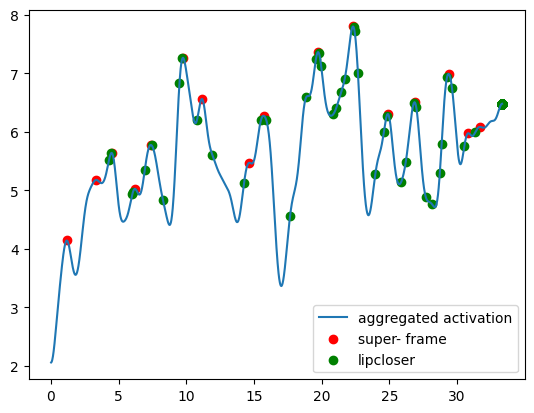

In [66]:
plt.plot(times, kf_times_aggregate, label="aggregated activation")
plt.scatter(times[extremes_filtered], kf_times_aggregate[extremes_filtered], c="r", label="super- frame")
# plt.scatter(times[vowel_index_in_times], kf_times_aggregate[vowel_index_in_times], c="g", label="vowels")
# plt.scatter(times[consonant_index_in_times], kf_times_aggregate[consonant_index_in_times], c="y", label="consonants")
plt.scatter(times[lipcloser_index_in_times], kf_times_aggregate[lipcloser_index_in_times], c="g", label="lipcloser")
plt.legend()

# Collapse Extreme Keyframe

In [67]:
superframes         # all the superframes
vals_dict           # all the motion curves
times               # time array
extremes_filtered   # pretty much the superframes
labeled_key_frame_dict 
print()

In [68]:
output_vals_dict = copy.deepcopy(vals_dict)
control_point_curves_dict: dict[str, MarlarkiRelativeTimeInterpolation] = {}

for key in output_vals_dict:
    kfs = labeled_key_frame_dict[key]
    ctpt_t = []
    ctpt_y = []
    for i in kfs:
        ctpt_t.append(times[i[0]])
        ctpt_y.append(vals_dict[key][i[0]])
    interp = MarlarkiRelativeTimeInterpolation(np.array(times), np.array(output_vals_dict[key]), np.array(ctpt_t), np.array(ctpt_y))
    control_point_curves_dict[key] = interp



# print(superframes[0].frame_off_sets.keys())
for i in range(0, len(superframes)):
    superframe = superframes[i]
    for key in superframe.frame_off_sets:
        offset = superframe.frame_off_sets[key]
        interp = control_point_curves_dict[key]
        # print(offset + superframe.frame_center)
        time_of_ctpt = times[offset + superframe.frame_center]
        ctpt_index = binary_search_for_left(interp.ctpt_x, time_of_ctpt)
        control_point_curves_dict[key].update_x(ctpt_index, times[superframe.frame_center] - time_of_ctpt)
collapsed_val_dict = {}
for key in control_point_curves_dict:
    # print(control_point_curves_dict[key].ctpt_x_delta)
    collapsed_val_dict[key] = control_point_curves_dict[key].eval(times)

In [69]:
model = BasicBlendshapeModel()
model = load_blendshape_model(model_path, model)
animation = BlendshapeAnimation(model, values_dict=collapsed_val_dict, ts =times)
play_animation(animation, save_video=True, video_path="/Users/evanpan/Desktop/collapsed.mp4")


[Open3D WARNING] GLFW Error: Cocoa: Failed to find service port for display
Moviepy - Building video /Users/evanpan/Desktop/collapsed.mp4.
Moviepy - Writing video /Users/evanpan/Desktop/collapsed.mp4



Moviepy - Done !
Moviepy - video ready /Users/evanpan/Desktop/collapsed.mp4


In [44]:
output_vals_dict = copy.deepcopy(vals_dict)
control_point_curves_dict: dict[str, MarlarkiRelativeTimeInterpolation] = {}

for key in output_vals_dict:
    kfs = labeled_key_frame_dict[key]
    ctpt_t = []
    ctpt_y = []
    for i in kfs:
        ctpt_t.append(times[i[0]])
        ctpt_y.append(vals_dict[key][i[0]])
    interp = MarlarkiRelativeTimeInterpolation(np.array(times), np.array(output_vals_dict[key]), np.array(ctpt_t), np.array(ctpt_y))
    control_point_curves_dict[key] = interp



print(superframes[0].frame_off_sets.keys())
for i in range(0, len(superframes)):
    superframe = superframes[i]
    for key in superframe.frame_off_sets:
        offset = superframe.frame_off_sets[key]
        interp = control_point_curves_dict[key]
        # print(offset + superframe.frame_center)
        time_of_ctpt = times[offset + superframe.frame_center]
        ctpt_index = binary_search_for_left(interp.ctpt_x, time_of_ctpt)
        control_point_curves_dict[key].update_x(ctpt_index, -times[superframe.frame_center] + time_of_ctpt)
un_collapsed_val_dict = {}
for key in control_point_curves_dict:
    print(control_point_curves_dict[key].ctpt_x_delta)
    un_collapsed_val_dict[key] = control_point_curves_dict[key].eval(times)

dict_keys(['browDownLeft', 'browDownRight', 'browInnerUp', 'cheekPuff', 'eyeLookInLeft', 'eyeLookOutRight', 'eyeLookUpLeft', 'eyeLookUpRight', 'eyeSquintLeft', 'eyeSquintRight', 'eyeWideLeft', 'eyeWideRight', 'jawForward', 'jawLeft', 'jawOpen', 'mouthClose', 'mouthFrownLeft', 'mouthFrownRight', 'mouthFunnel', 'mouthLowerDownLeft', 'mouthLowerDownRight', 'mouthPucker', 'mouthRollLower', 'mouthRollUpper', 'mouthShrugLower', 'mouthShrugUpper', 'mouthStretchLeft', 'mouthStretchRight', 'mouthUpperUpLeft'])
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0.1499999999999999, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.16666666666666652, 0, 0.08333333333333348, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.15000000000000036, 0, 0, 0, 0, 0, 0, 0, 0.08333333333333304, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.15000000000000036, 0, 0, 0, 0, 0, 0.033333333333333215, 0, 0, 0, 0, 0, 0, 0.11666666666666714, 0, 0, 0, 0, 0, 0, 0.13333333333333464, 0, 0, 0, 0, 0, 0, 0.13333333333333286, 0, 0, 0, 0, 0, 0, 0.049999999999998934, 0, 0, 0, 0,

/var/folders/dj/fb2zmgq93sv7xnbfzqj2n3pm0000gn/T/ipykernel_76746/771978911.py:86: RuntimeWarning: invalid value encountered in double_scalars
  x_prime = (x - self.x[curve_range[0]]-curve_delta[0]) / (self.x[curve_range[1]] + curve_delta[1] - self.x[curve_range[0]] - curve_delta[0])


[0.033333333333333215, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.1166666666666667, 0, 0, 0, 0, 0.18333333333333357, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.10000000000000053, 0, 0, 0, 0, 0, 0, 0.08333333333333304, 0, 0, 0, 0, 0, 0, 0, 0, 0.14999999999999947, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.13333333333333375, 0, 0, 0, 0, 0.18333333333333357, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.08333333333333393, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.08333333333333393, 0, 0, 0, 0, 0, 0, 0, 0, 0.14999999999999858, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.16666666666666607, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.11666666666666714, 0, 0, 0, 0, 0, 0.033333333333333215, 0, 0, 0, 0, 0, 0.0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.09999999999999964, 0, 0, 0, 0, 0, 0, 0, 0.033333333333333215, 0, 0, 0, 0, 0, 0.15000000000000213, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.13333333333333286, 0, 0, 0, 0, 0, 0, 0, 0.16666666666666785, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.15000000000000213, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [33]:
model = BasicBlendshapeModel()
model = load_blendshape_model(model_path, model)
animation = BlendshapeAnimation(model, values_dict=un_collapsed_val_dict, ts =times)
play_animation(animation, save_video=True, video_path="/Users/evanpan/Desktop/exaggerated.mp4")


[Open3D WARNING] GLFW Error: Cocoa: Failed to find service port for display
[Open3D WARNING] GLFW Error: Cocoa: Failed to find service port for display
Moviepy - Building video /Users/evanpan/Desktop/exaggerated.mp4.
Moviepy - Writing video /Users/evanpan/Desktop/exaggerated.mp4



Moviepy - Done !
Moviepy - video ready /Users/evanpan/Desktop/exaggerated.mp4
